# Objective

To create a model capable of predicting whether a user of the telecommunications company "Interconnect" plans to cancel their service. This will allow the company to retain the user by offering a special plan or promotion.


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import time

In [6]:
# Import datasets
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

contract.info()
personal.info()
internet.info()
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   D

In [3]:
# Create the churn column to determine whether the user canceled the service or not
contract['Churn'] = contract['EndDate'] != 'No'
# Convert time columns to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], errors='coerce')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')
# Convert TotalCharges to numeric
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.loc[contract['TotalCharges'].isna(), 'TotalCharges'] = 0.0

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   bool          
dtypes: bool(1), datetime64[ns](2), float64(2), object(4)
memory usage: 447.2+ KB


In [4]:
# Simplify to binary
personal['gender'] = personal['gender'].map({'Female': 0, 'Male': 1})
personal['Partner'] = personal['Partner'].map({'No': 0, 'Yes': 1})
personal['Dependents'] = personal['Dependents'].map({'No': 0, 'Yes': 1})
# Categorical variables were converted to numeric to facilitate processing
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   int64 
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int64 
 4   Dependents     7043 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 275.2+ KB


In [5]:
# Columns to transform
cols_servicios = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Apply .map() column by column
# Categorical variables were converted to numeric to facilitate processing
for col in cols_servicios:
    internet[col] = internet[col].map({'Yes': 1, 'No': 0})

internet = pd.get_dummies(internet, columns=['InternetService'], drop_first=False)
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   customerID                   5517 non-null   object
 1   OnlineSecurity               5517 non-null   int64 
 2   OnlineBackup                 5517 non-null   int64 
 3   DeviceProtection             5517 non-null   int64 
 4   TechSupport                  5517 non-null   int64 
 5   StreamingTV                  5517 non-null   int64 
 6   StreamingMovies              5517 non-null   int64 
 7   InternetService_DSL          5517 non-null   uint8 
 8   InternetService_Fiber optic  5517 non-null   uint8 
dtypes: int64(6), object(1), uint8(2)
memory usage: 312.6+ KB


In [6]:
# Apply .map() to 'MultipleLines' column
phone['MultipleLines'] = phone['MultipleLines'].map({'Yes': 1, 'No': 0})
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.5+ KB


In [7]:
# Merging datasets
df_full = contract.merge(personal, on='customerID', how='left')
df_full = df_full.merge(internet, on='customerID', how='left')
df_full = df_full.merge(phone, on='customerID', how='left')

# Check rows and columns of the merged data frame
print(df_full.shape)
df_full.info()

(7043, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   customerID                   7043 non-null   object        
 1   BeginDate                    7043 non-null   datetime64[ns]
 2   EndDate                      1869 non-null   datetime64[ns]
 3   Type                         7043 non-null   object        
 4   PaperlessBilling             7043 non-null   object        
 5   PaymentMethod                7043 non-null   object        
 6   MonthlyCharges               7043 non-null   float64       
 7   TotalCharges                 7043 non-null   float64       
 8   Churn                        7043 non-null   bool          
 9   gender                       7043 non-null   int64         
 10  SeniorCitizen                7043 non-null   int64         
 11  Partner                      704

In [8]:
# Fill in the missing values with 0, except for the End Date column, 
# since it is assumed that the missing data in the service columns is due to not having contracted the service
cols_to_int = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService_DSL',
               'InternetService_Fiber optic', 'MultipleLines']
df_full[cols_to_int] = df_full[cols_to_int].fillna(0).astype('int64')

num_duplicados = df_full['customerID'].duplicated().sum() # Verify that there are no duplicate customerID
print("Number of duplicate customerID:", num_duplicados)

Number of duplicate customerID: 0


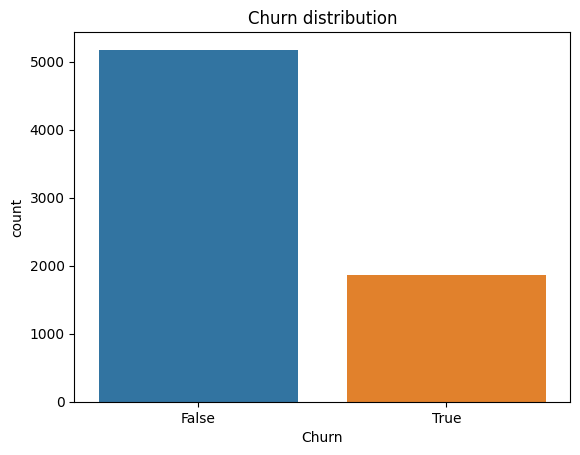

In [9]:
# Churn distribution
sns.countplot(x='Churn', data=df_full)
plt.title('Churn distribution')
plt.show()

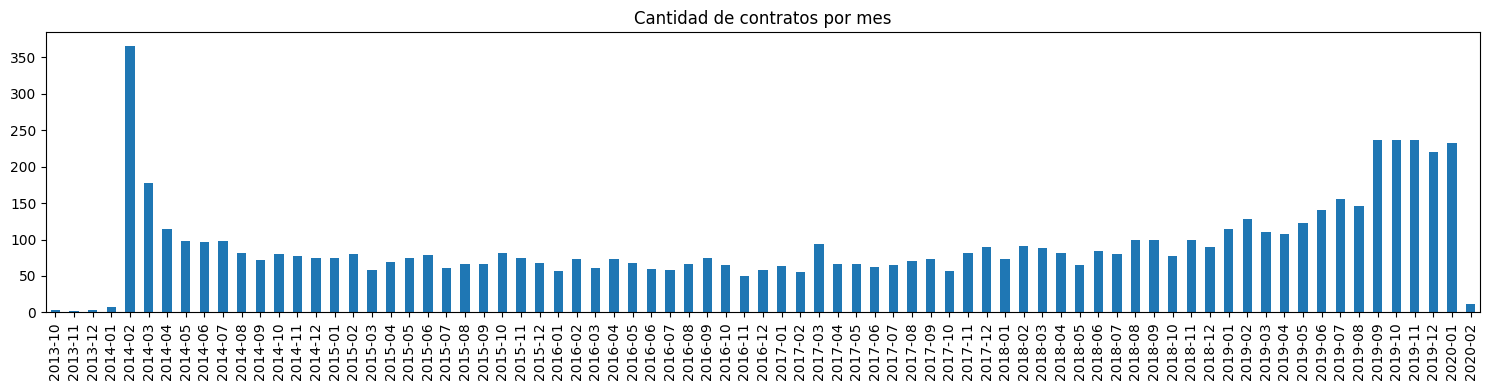

In [10]:
# Distribution of contracts over time
df_full['BeginDate'].min(), df_full['BeginDate'].max()

df_full['BeginDate'].dt.to_period('M').value_counts().sort_index().plot(kind='bar', figsize=(15,4))
plt.title('Cantidad de contratos por mes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
# Define the date range to retain since no significant data was observed outside of these dates
start_date = pd.to_datetime('2014-02-01')
end_date = pd.to_datetime('2020-02-01')

# Filter the DataFrame to retain data in the defined range
df_full = df_full[(df_full['BeginDate'] >= start_date) & (df_full['BeginDate'] < end_date)]

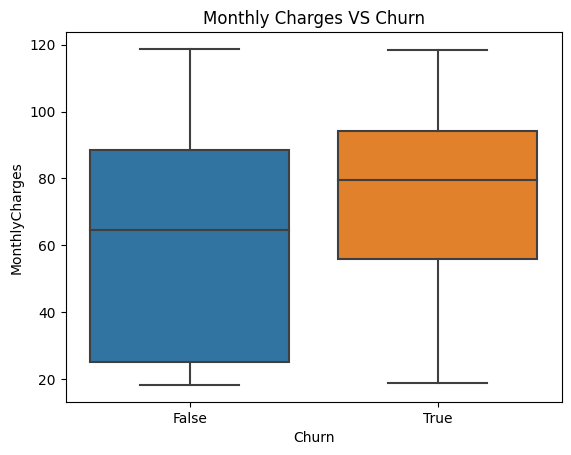

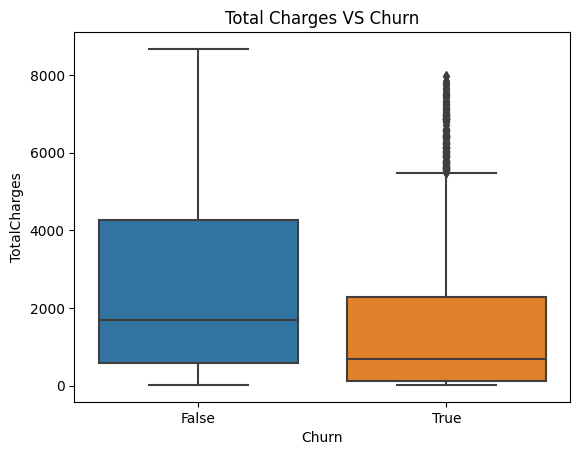

In [12]:
# Correlation between churn and service charges
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_full)
plt.title('Monthly Charges VS Churn')
plt.show()

sns.boxplot(x='Churn', y='TotalCharges', data=df_full)
plt.title('Total Charges VS Churn')
plt.show()

In [13]:
# Verify that there are no outliers in the TotalCharges column
q1 = df_full['TotalCharges'].quantile(0.25)
q3 = df_full['TotalCharges'].quantile(0.75)
iqr = q3 - q1
outliers = df_full[(df_full['TotalCharges'] < (q1 - 1.5*iqr)) | (df_full['TotalCharges'] > (q3 + 1.5*iqr))]
print(f"Outliers in TotalCharges: {outliers.shape[0]}")

Outliers in TotalCharges: 0


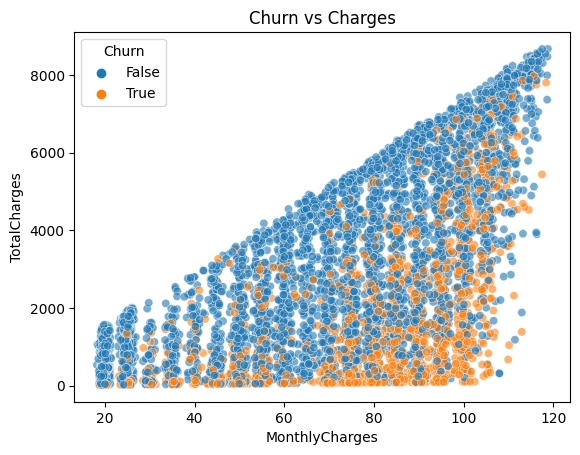

In [14]:
sns.scatterplot(data=df_full, x='MonthlyCharges', y='TotalCharges', hue='Churn', alpha=0.6)
plt.title('Churn vs Charges')
plt.show()

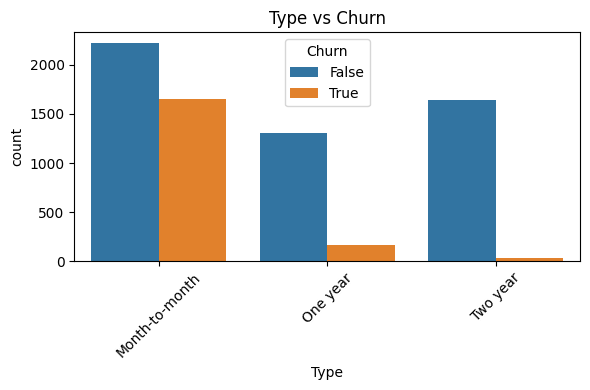

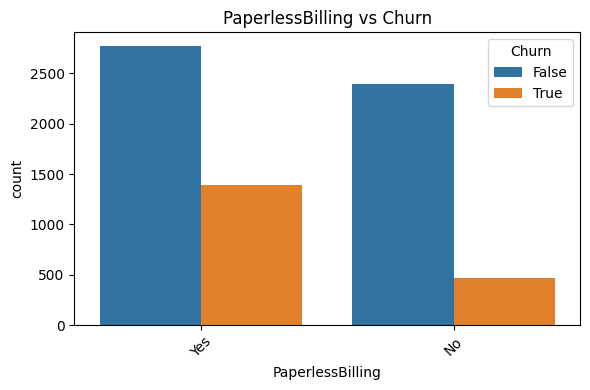

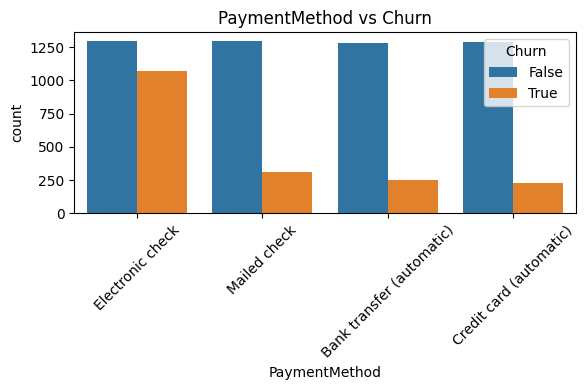

In [15]:
# Relation with categorical variables
categoricas = ['Type', 'PaperlessBilling', 'PaymentMethod']
for col in categoricas:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='Churn', data=df_full)
    plt.title(f'{col} vs Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

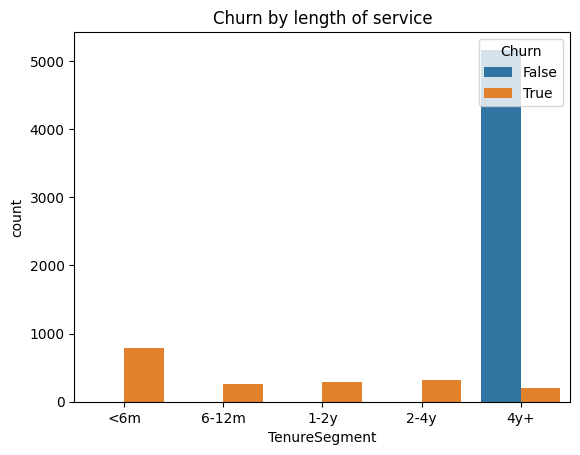

In [16]:
# Customer tenure
df_full['TenureMonths'] = ((df_full['EndDate'].fillna(pd.Timestamp('today')) - df_full['BeginDate']) / pd.Timedelta(days=30)).astype(int)

bins = [0, 6, 12, 24, 48, df_full['TenureMonths'].max()]
labels = ['<6m', '6-12m', '1-2y', '2-4y', '4y+']
df_full['TenureSegment'] = pd.cut(df_full['TenureMonths'], bins=bins, labels=labels)

sns.countplot(data=df_full, x='TenureSegment', hue='Churn')
plt.title('Churn by length of service')
plt.show()

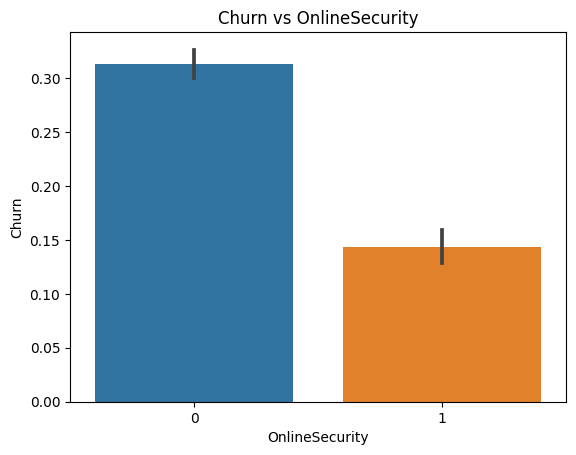

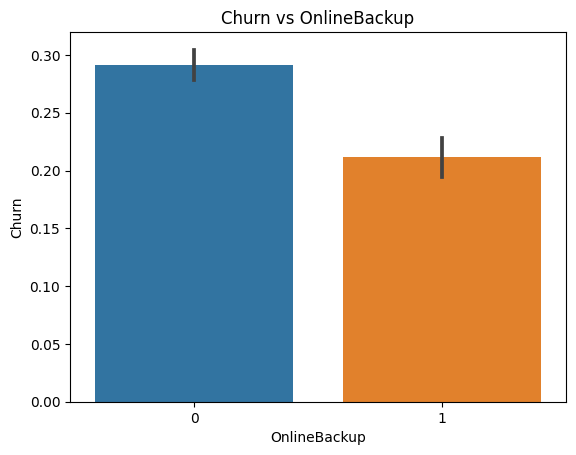

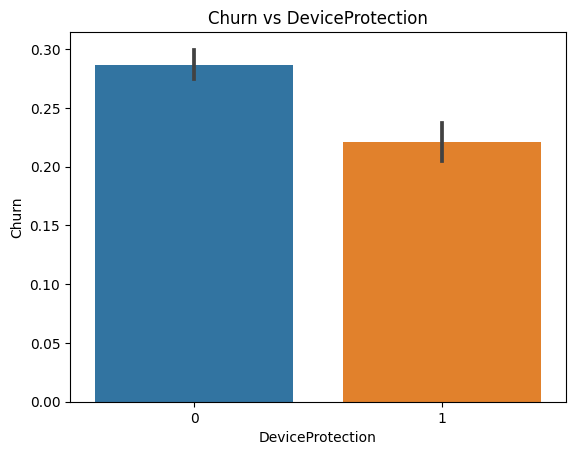

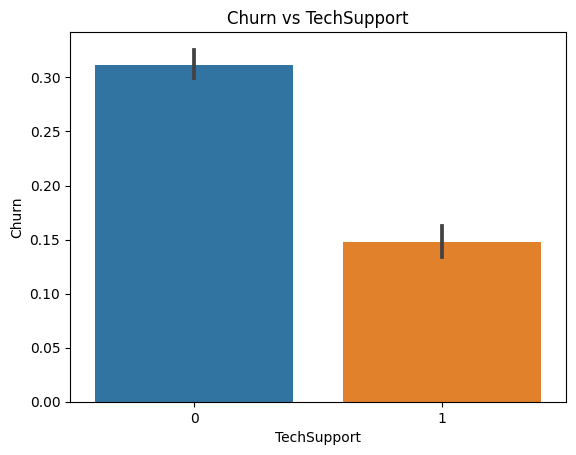

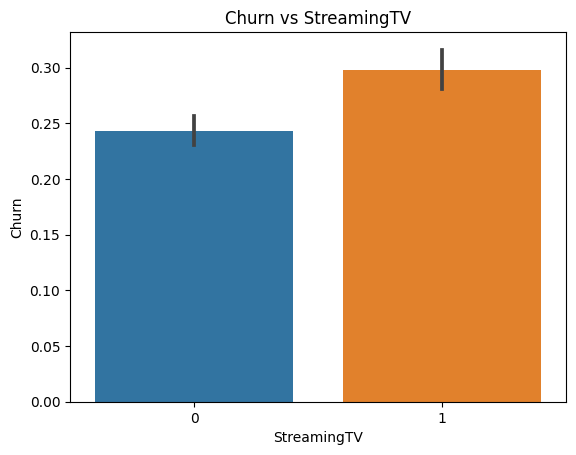

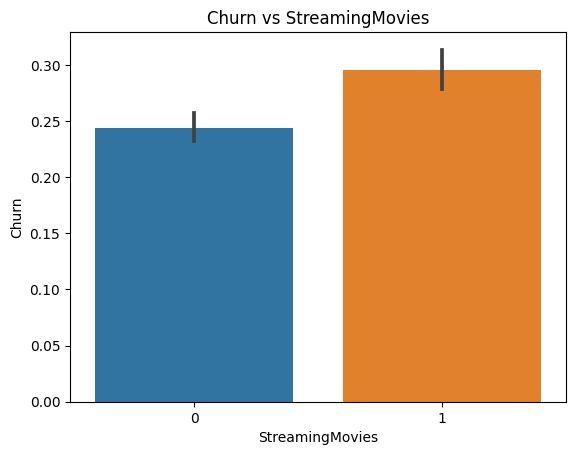

In [17]:
# Correlation between services and churn
servicios = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for servicio in servicios:
    sns.barplot(x=servicio, y='Churn', data=df_full)
    plt.title(f'Churn vs {servicio}')
    plt.show()

In [18]:
df_full.groupby('Churn')[['MonthlyCharges']].describe() # Statistical summary of the MonthlyCharges column for each group of the Churn variable

MonthlyCharges                                                      \
               count       mean        std    min    25%     50%     75%   
Churn                                                                      
False         5163.0  61.307408  31.094557  18.25  25.10  64.450  88.475   
True          1854.0  74.247869  24.617857  18.85  55.95  79.575  94.100   

               
          max  
Churn          
False  118.75  
True   118.35

In [19]:
df_full.groupby('Churn')[['TotalCharges']].describe() # Statistical summary of the Total Charges column for each group of the Churn variable

TotalCharges                                                      \
             count         mean          std    min      25%       50%   
Churn                                                                    
False       5163.0  2555.344141  2329.456984  18.80  577.825  1683.600   
True        1854.0  1487.556742  1829.329626  18.85  131.200   679.425   

                           
             75%      max  
Churn                      
False  4264.1250  8672.45  
True   2274.7625  7968.85

In [20]:
df_full.groupby('Churn')[['TenureMonths']].describe() # Statistical summary of the TenureMonths column for each group of the Churn variable

TenureMonths                                                        
             count        mean        std   min   25%    50%    75%    max
Churn                                                                     
False       5163.0  103.253535  24.501876  66.0  80.0  104.0  127.0  138.0
True        1854.0   17.569040  19.066287   1.0   2.0   10.0   28.0   72.0

In [21]:
# Categorical variables were converted to numeric to facilitate processing
df_full = pd.get_dummies(df_full, columns=['Type'], drop_first=False)
df_full['PaperlessBilling'] = df_full['PaperlessBilling'].map({'Yes': 1, 'No': 0})
df_full = pd.get_dummies(df_full, columns=['PaymentMethod'], drop_first=False)

df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7017 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   customerID                               7017 non-null   object        
 1   BeginDate                                7017 non-null   datetime64[ns]
 2   EndDate                                  1854 non-null   datetime64[ns]
 3   PaperlessBilling                         7017 non-null   int64         
 4   MonthlyCharges                           7017 non-null   float64       
 5   TotalCharges                             7017 non-null   float64       
 6   Churn                                    7017 non-null   bool          
 7   gender                                   7017 non-null   int64         
 8   SeniorCitizen                            7017 non-null   int64         
 9   Partner                                  

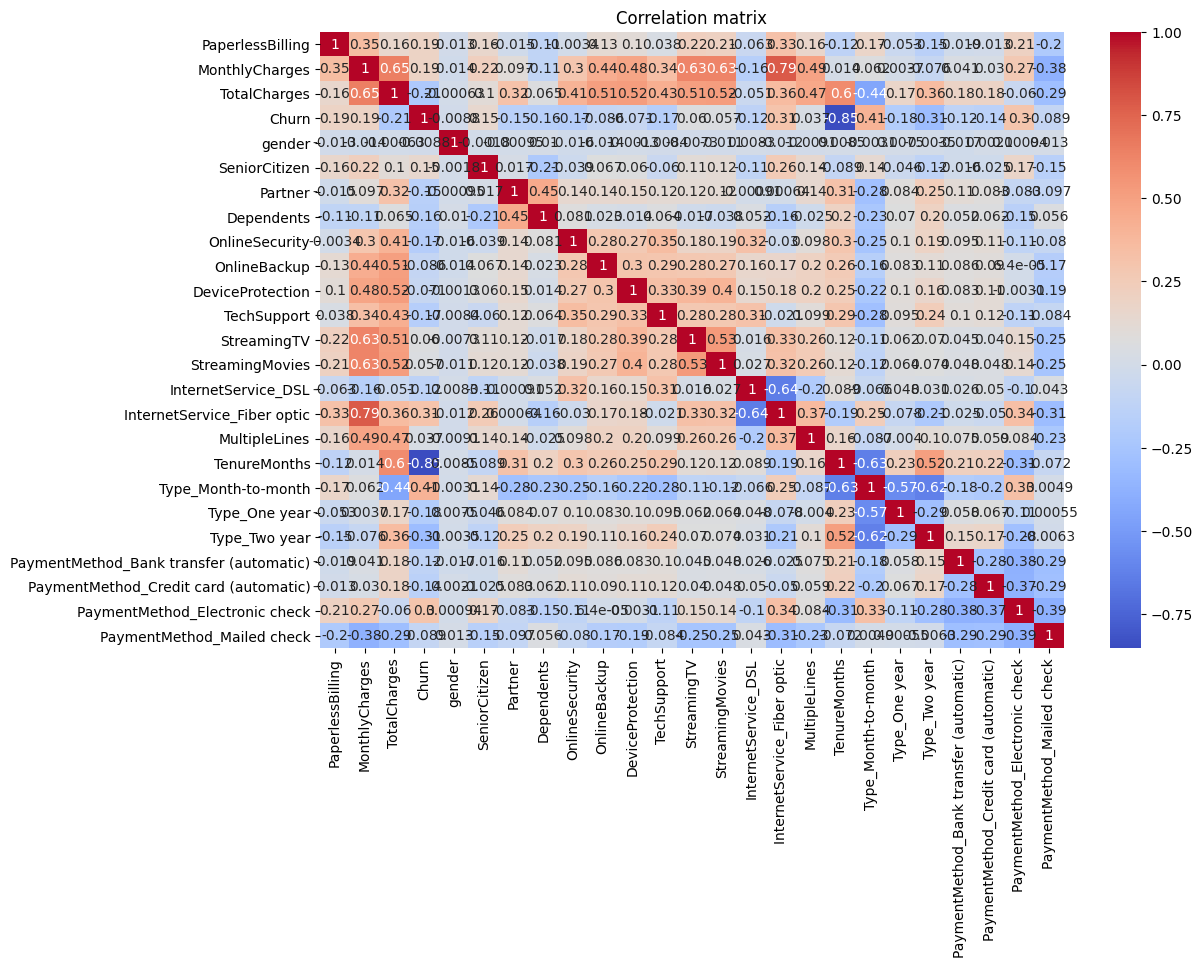

In [22]:
# Convert the Churn column to integer type
df_full['Churn'] = df_full['Churn'].astype(int)
corr = df_full.corr()

# Generate a correlation matrix between all numeric columns
corr = df_full.select_dtypes(include='number').corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [23]:
# Correlation of numerical columns with Churn
numeric_df = df_full.select_dtypes(include=[np.number])
correlaciones = numeric_df.corr()
print(correlaciones['Churn'].sort_values(ascending=False))

Churn                                      1.000000
Type_Month-to-month                        0.410251
InternetService_Fiber optic                0.306645
PaymentMethod_Electronic check             0.303164
PaperlessBilling                           0.190690
MonthlyCharges                             0.189781
SeniorCitizen                              0.151407
StreamingTV                                0.060003
StreamingMovies                            0.057148
MultipleLines                              0.036993
gender                                    -0.008783
DeviceProtection                          -0.070949
OnlineBackup                              -0.086113
PaymentMethod_Mailed check                -0.089133
PaymentMethod_Bank transfer (automatic)   -0.120247
InternetService_DSL                       -0.124051
PaymentMethod_Credit card (automatic)     -0.136302
Partner                                   -0.152384
Dependents                                -0.163528
TechSupport 

In [24]:
# Define features and target
features = df_full.drop(columns=['customerID', 'BeginDate', 'EndDate', 'TenureSegment', 'Churn', 'TenureMonths'])
target = df_full['Churn'].astype(int)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42, stratify=target)

In [25]:
# Normalize for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    'Regresión Logística': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# Training and evaluation
results = []

for name, model in models.items():
    print(f'\n Training {name}...')
    start = time.time()

    if name == 'Regresión Logística':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    end = time.time()
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'AUC-ROC': round(auc, 4),
        'Time (seg)': round(end - start, 2)
    })

# Summary
df_results = pd.DataFrame(results).sort_values(by='AUC-ROC', ascending=False)
print('\n Model comparison:')
print(df_results)



 Training Regresión Logística...

 Training Random Forest...

 Training GradientBoosting...

 Training XGBoost...

 Training LightGBM...

 Training CatBoost...

 Model comparison:
                 Model  Accuracy  AUC-ROC  Time (seg)
2     GradientBoosting    0.7989   0.8370        0.62
5             CatBoost    0.7937   0.8348        1.90
4             LightGBM    0.7949   0.8286        1.97
0  Regresión Logística    0.7863   0.8240        0.01
3              XGBoost    0.7738   0.8190        2.87
1        Random Forest    0.7744   0.8084        0.57


In [26]:
# Finding the best parameters for GradientBoostingClassifier
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

gbc = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gbc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score (ROC-AUC) in validation:", grid_search.best_score_)

# Evaluation in the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print("Test accuracy:", acc)
print("AUC-ROC:", auc)


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Best score (ROC-AUC) in validation: 0.8527292980319421
Test accuracy: 0.7988603988603988
AUC-ROC: 0.8399129250247069
